# Testing transcriptions

In [25]:
def get_transcript(file_name: str):
    return open(file_name, "r").read()


transcript = get_transcript("data/mcclendon_tapes.txt")
print(transcript[:100])

okay so um we were talkin about that time granddaddy slipped behind the stove yeah that was in the s


## Ensure LLS is active + the model we are using to test exists

In [30]:
from llama_stack_client import LlamaStackClient

model = "llama3.2:1b"
client = LlamaStackClient(
    base_url="http://localhost:8321"
)

models = client.models.list()
assert model in [m.identifier for m in models]

INFO:httpx:HTTP Request: GET http://localhost:8321/v1/models "HTTP/1.1 200 OK"


In [29]:
client.inference.chat_completion(model_id=model, messages=[{"role": "user", "content": "What is the transcript?"}])

INFO:httpx:HTTP Request: POST http://localhost:8321/v1/inference/chat-completion "HTTP/1.1 200 OK"


ChatCompletionResponse(completion_message=CompletionMessage(content="This conversation has just begun. There is no transcript to share yet. What would you like to talk about or ask? I can summarize our conversation at the end if you'd like.", role='assistant', stop_reason='end_of_turn', tool_calls=[]), logprobs=None, metrics=[Metric(metric='prompt_tokens', value=15.0, unit=None), Metric(metric='completion_tokens', value=47.0, unit=None), Metric(metric='total_tokens', value=62.0, unit=None)])

## Determine GPU to use, if not default to CPU

In [25]:
import torch

def determine_torch_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = determine_torch_device()

In [31]:
from pyannote.audio import Pipeline
import whisper

audio = "data/sample_two_people.wav"
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization").to(determine_torch_device())

diarization = pipeline(audio)

print(diarization)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1. Bad things might happen unless you revert torch to 1.x.
[ 00:00:00.030 -->  00:00:04.367] A SPEAKER_00
[ 00:00:04.485 -->  00:00:19.842] B SPEAKER_01


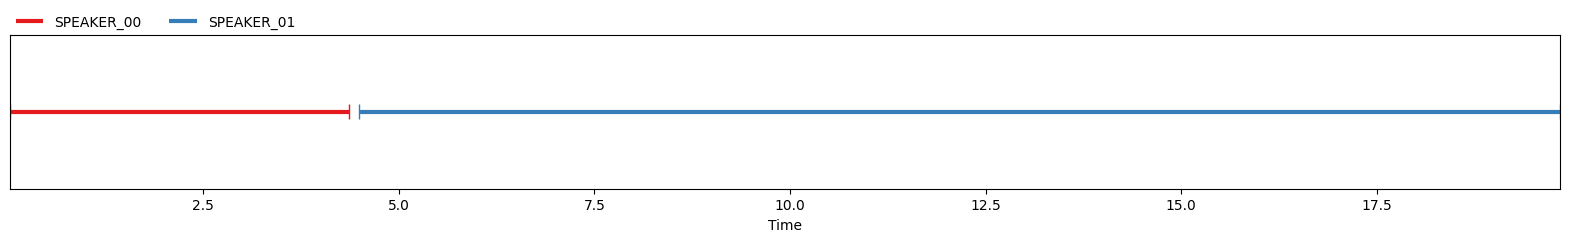

In [32]:
diarization

In [37]:
for segment in diarization.itersegments():
    print(segment)

for turn in diarization.itertracks(yield_label=True):
    print(turn)

[ 00:00:00.030 -->  00:00:04.367]
[ 00:00:04.485 -->  00:00:19.842]
(<Segment(0.0309687, 4.36784)>, 'A', 'SPEAKER_00')
(<Segment(4.48597, 19.8422)>, 'B', 'SPEAKER_01')


### Seperate speaker segments

In [49]:
def get_speaker_segments(diarization):
    segments = {}
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        segments.setdefault(speaker, []).append(turn)
    return segments


diar_segments = get_speaker_segments(diarization)
diar_segments

{'SPEAKER_00': [<Segment(0.0309687, 4.36784)>],
 'SPEAKER_01': [<Segment(4.48597, 19.8422)>]}

In [43]:
model = whisper.load_model("base")

results = model.transcribe(audio)
results["segments"]

/Users/sglinton/dev/hub/.venv/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


[{'id': 0,
  'seek': 0,
  'start': 0.0,
  'end': 4.32,
  'text': ' Okay, so, um, we were talking about that time Granddaddy slipped behind the stove.',
  'tokens': [50364,
   1033,
   11,
   370,
   11,
   1105,
   11,
   321,
   645,
   1417,
   466,
   300,
   565,
   6757,
   20034,
   3173,
   28989,
   2261,
   264,
   19263,
   13,
   50580],
  'temperature': 0.0,
  'avg_logprob': -0.3059328445280441,
  'compression_ratio': 1.5466101694915255,
  'no_speech_prob': 0.04611587896943092},
 {'id': 1,
  'seek': 0,
  'start': 4.48,
  'end': 9.6,
  'text': ' Yeah, that was in the summer because I remember it was hot, like real hot, like stick to your chair, hot.',
  'tokens': [50588,
   865,
   11,
   300,
   390,
   294,
   264,
   4266,
   570,
   286,
   1604,
   309,
   390,
   2368,
   11,
   411,
   957,
   2368,
   11,
   411,
   2897,
   281,
   428,
   6090,
   11,
   2368,
   13,
   50844],
  'temperature': 0.0,
  'avg_logprob': -0.3059328445280441,
  'compression_ratio': 1.546

### Find the speaker based on the diarization

In [57]:
def assign_speakers(diarization_segments: dict, transcript_segments: dict):
    diarization_list = []
    for speaker, segs in diarization_segments.items():
        for seg in segs:
            diarization_list.append({'speaker': speaker, 'start': seg.start, 'end': seg.end})


    for ts in transcript_segments:
        mid = (ts["start"] + ts["end"]) / 2
        # find the speaker that is closest to the midpoint
        speaker = None

        for seg in diarization_list:
            if seg["start"] <= mid <= seg["end"]:
                speaker = seg["speaker"]
                print(speaker)
                break

assign_speakers(diar_segments, results["segments"])

SPEAKER_00
SPEAKER_01
SPEAKER_01
SPEAKER_01
